In [1]:
library(readr) # Read competition data files:
library(ggmap) # For map plotting
library(geosphere)


distance <- function(longitude, latitude) {        
        #Euclidian distances aren't accurate, use Haversine distance : http://en.wikipedia.org/wiki/Haversine_formula        
        dist1 <- distHaversine(c(stations[1,]$Longitude,stations[1,]$Latitude),c(longitude,latitude))
        dist2 <- distHaversine(c(stations[2,]$Longitude,stations[2,]$Latitude),c(longitude,latitude))
        

        if(dist1<dist2){
                return(1)
        }
        return(2)
}
data_path= "/Users/qiaolinchen/Documents/data_challenge/sparkbeyond/data/"
mapdata <- readRDS(paste0(data_path, "mapdata_copyright_openstreetmap_contributors.rds") )
train <- read.csv(paste0(data_path, "train.csv") )

# extact year from date
train$Year <- as.numeric(substr( as.character(train$Date), 1,4))
# make Virus variable for present-absence
train$Virus <-ifelse(train$WnvPresent ==0,"Absent","Present")


Loading required package: ggplot2
Loading required package: sp


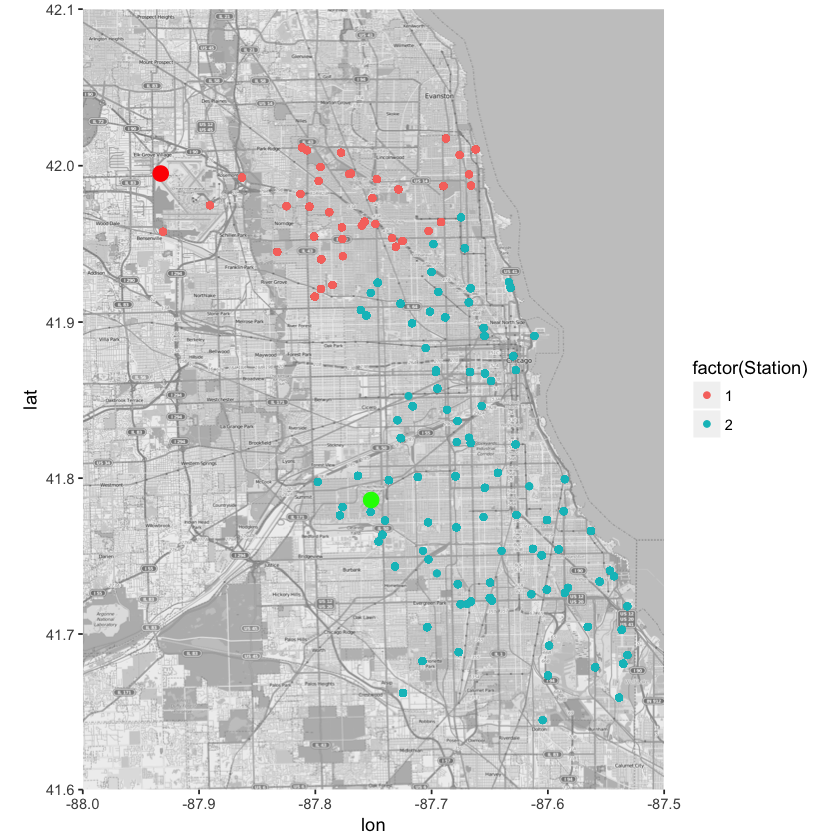

In [2]:
#Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
#Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

stations <-data.frame(c(1,2),c(41.995,41.786),c(-87.933,-87.752))
names(stations) <-c("Station","Latitude","Longitude")

train$Station <-mapply(distance,train$Longitude,train$Latitude)

#Let's make a plot to see if everything is OK
pl <- ggmap(mapdata)+geom_point(data=train,aes(x=Longitude,y=Latitude,color=factor(Station)))+geom_point(data=stations,aes(x=Longitude, y=Latitude,colour=Station),colour=c("red","green"),size=4)
pl
#ggsave("rplot.png", pl, dpi = 100, width = 10, height = 15, units="in")

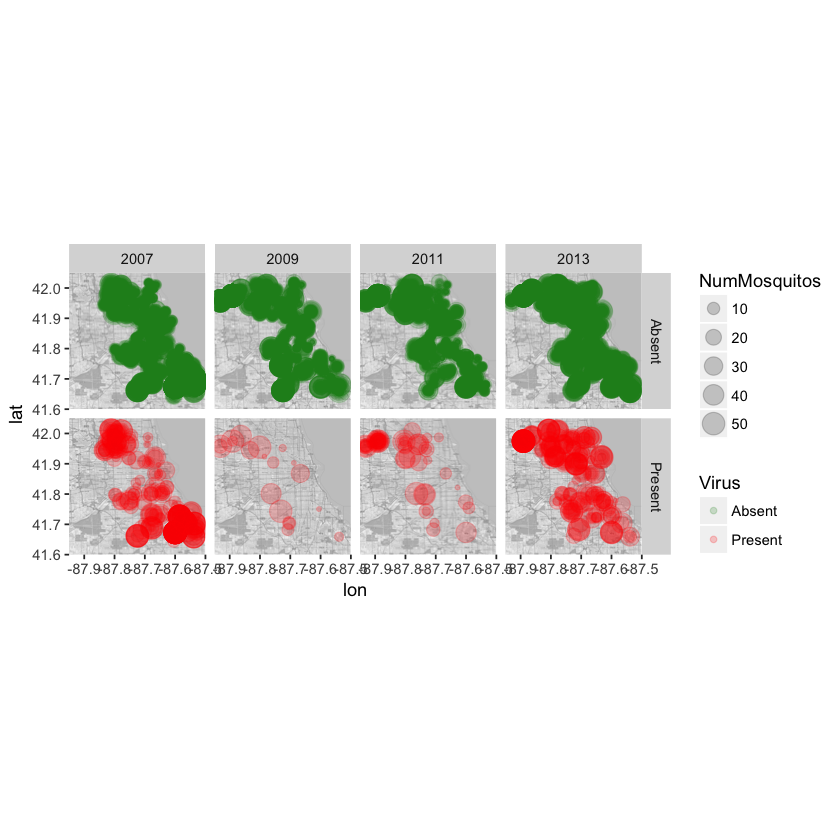

In [3]:
# facet graph of infectious mosquitos
ggmap(mapdata)+geom_point(data=train, aes(x=Longitude, y=Latitude, colour=Virus,size=NumMosquitos),alpha=0.2)+
scale_colour_manual(values =c("forestgreen","red"))+
facet_grid(Virus~Year)+
coord_equal(xlim = c(-87.95,-87.5),ylim = c(41.6,42.05))

#https://www.kaggle.com/thenokondi/facet-map-by-year-and-virus-status

Parsed with column specification:
cols(
  Date = col_date(format = ""),
  Address = col_character(),
  Species = col_character(),
  Block = col_integer(),
  Street = col_character(),
  Trap = col_character(),
  AddressNumberAndStreet = col_character(),
  Latitude = col_double(),
  Longitude = col_double(),
  AddressAccuracy = col_integer(),
  NumMosquitos = col_integer(),
  WnvPresent = col_integer()
)
Parsed with column specification:
cols(
  .default = col_character(),
  Station = col_integer(),
  Date = col_date(format = ""),
  Tmax = col_integer(),
  Tmin = col_integer(),
  DewPoint = col_integer(),
  ResultSpeed = col_double(),
  ResultDir = col_integer()
)
See spec(...) for full column specifications.


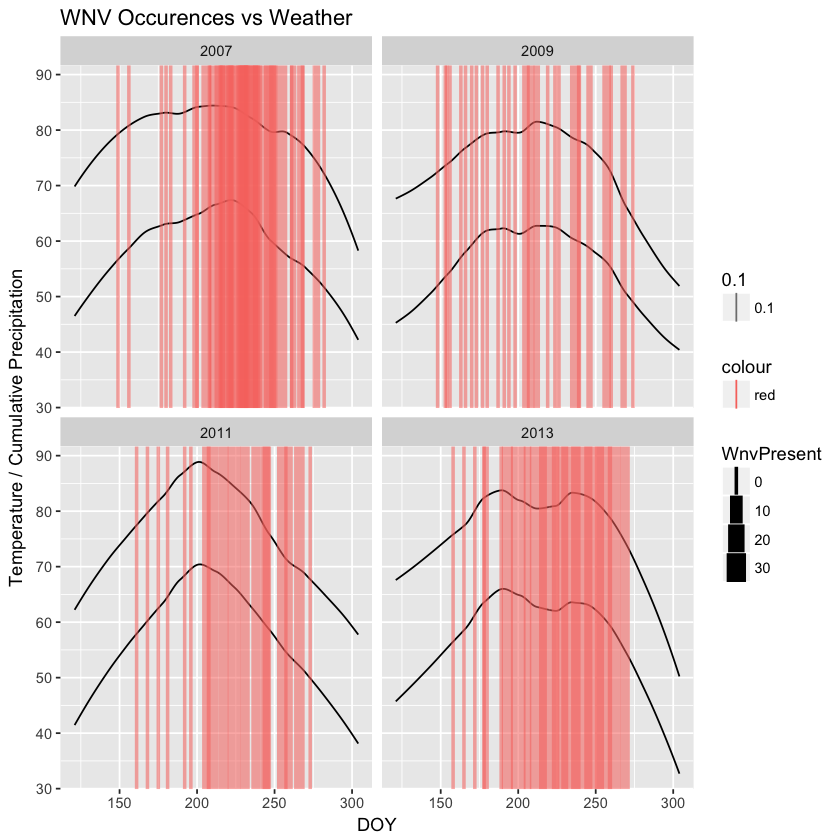

In [6]:

# Read competition data files:
library(readr)
train <- read_csv(paste0(data_path, "train.csv") )
weather <- read_csv(paste0(data_path , "weather.csv") )

# Generate output files with write_csv(), plot() or ggplot()
# Any files you write to the current directory get shown as outputs

library(plyr)
library(ggplot2)

station_1 = weather[weather$Station == 1, c('Date','Tmax','Tmin','PrecipTotal')]
station_1$Year = format(station_1$Date,'%Y')
station_1$DOY = as.numeric(strftime(station_1$Date,'%j'))
#station_1$PrecipTotal = as.numeric(levels(station_1$PrecipTotal))[station_1$PrecipTotal]
#station_1$PrecipTotal[is.na(station_1$PrecipTotal)] = 0

station_1 = ddply(station_1, .(Year), transform, Tmax_smooth = loess(Tmax ~ DOY,span=.5)$fitted)
station_1 = ddply(station_1, .(Year), transform, Tmin_smooth = loess(Tmin ~ DOY,span=.5)$fitted)
station_1 = station_1[station_1$Year %in%  c(2007, 2009, 2011, 2013) , ]
#station_1 = ddply(station_1, .(Year), transform, Precip_cumsum = cumsum(PrecipTotal))


WNV = train[,c('Date','WnvPresent')]
WNV = aggregate(WnvPresent ~ Date, data = WNV, FUN = sum)
WNV$Year = format(WNV$Date,'%Y')
WNV$DOY = as.numeric(strftime(WNV$Date,'%j'))


p2 <- ggplot() + 
  geom_line(aes(DOY,Tmax_smooth), data = station_1) +
  geom_line(aes(DOY,Tmin_smooth), data = station_1) +
  #geom_line(aes(DOY,Precip_cumsum), col='blue', data = station_1) +
  geom_vline(aes(xintercept = DOY,alpha = .1,
             colour='red',size=WnvPresent),data=WNV) + 
  labs(x = 'DOY', y = 'Temperature / Cumulative Precipitation',
       title = 'WNV Occurences vs Weather') + 
  facet_wrap(~Year)

p2

#ggsave("rain_plot.png", p2, dpi = 100, width = 12, height = 10, units="in")
#https://www.kaggle.com/breszke/plot-wnv-vs-weather/code